In [9]:
%%time
import sys;
#!{sys.executable} -m pip install -r requirements.txt
 

CPU times: user 0 ns, sys: 6 µs, total: 6 µs
Wall time: 10.7 µs


In [10]:
%%time
import boto3
import sagemaker

session = sagemaker.Session() 
region = session.boto_region_name 

bucket = 'sagemaker-jfox'
 
prefix = 'sagemaker/xgboost'
role = sagemaker.get_execution_role()

print(f'Bucket {bucket} in region {region}')

Bucket sagemaker-jfox in region eu-west-1
CPU times: user 45.2 ms, sys: 243 µs, total: 45.4 ms
Wall time: 73.9 ms


In [11]:
%%time
import random
import pandas as pd
raw_data_filename = 'fraudhead.csv'

s3 = boto3.resource('s3', region_name=region)
#s3.Bucket(bucket).download_file(raw_data_filename, raw_data_filename)
percent_to_read=10
fraction_to_read=percent_to_read/100 # Divide by 1000 and not 100 as expected?
df = pd.read_csv('./'+raw_data_filename,  skiprows=lambda i: i>0 and random.random() > fraction_to_read)
pd.set_option('display.max_rows', 10) 
pd.set_option('display.width', 1000)

print('Length', len(df))
target_col='isFraud'
df

Length 104
CPU times: user 13.1 ms, sys: 46 µs, total: 13.1 ms
Wall time: 11.9 ms


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,2560.74,C1648232591,5070.0,2509.26,M972865270,0.0,0.00,0,0
1,1,CASH_OUT,229133.94,C905080434,15325.0,0.00,C476402209,5083.0,51513.44,0,0
2,1,DEBIT,9302.79,C1566511282,11299.0,1996.21,C1973538135,29832.0,16896.70,0,0
3,1,PAYMENT,8009.09,C1053967012,10968.0,2958.91,M295304806,0.0,0.00,0,0
4,1,PAYMENT,24213.67,C1238616099,0.0,0.00,M70695990,0.0,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
99,1,DEBIT,8679.29,C1233505227,150592.0,141912.71,C1877453512,21056.0,0.00,0,0
100,1,PAYMENT,9574.31,C1873121466,52463.0,42888.69,M115945887,0.0,0.00,0,0
101,1,CASH_IN,55827.09,C1959708563,9907.0,65734.09,C1850180796,19873.0,1268668.92,0,0
102,1,PAYMENT,1617.90,C1004430079,507865.0,506247.10,M1379148981,0.0,0.00,0,0


Counts of each class to determine imbalance.

In [12]:
 
def count_positive_and_negative(df):
    num_positive = len(df.loc[  df[target_col] == 1 ])
    num_negative = len(df) - num_positive
    return num_positive, num_negative

num_positive, num_negative = count_positive_and_negative(df)

print('Fraud', num_positive, '; Not fraud', num_negative, '; Total', len(df))

Fraud 0 ; Not fraud 104 ; Total 104


Not using `isFlaggedFraud`.

In [13]:
df = df.drop(['isFlaggedFraud'], axis=1)

Plot distribution of positive vs negative, in log scale because of the imbalance

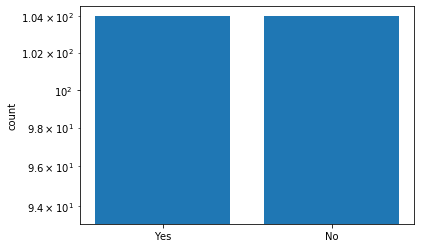

In [14]:
import math
import matplotlib.pyplot as plt   
def plot_positive_negative_counts(df, target_col):
    val_counts=df[target_col].value_counts()
    fig, ax = plt.subplots()
    ax.set(yscale="log")
    plt.bar(['Yes', 'No'], val_counts)
    plt.ylabel('count')
    plt.show()
    
plot_positive_negative_counts(df,target_col)

Scale the numerical values.

In [15]:
#Split numerical from non-numerical
columns = df.columns
numerical_cols = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
other_col =[c for c in columns if  c not in numerical_cols]
df_other = df[other_col]

df_num = df[numerical_cols]
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_num = pd.DataFrame(scaler.fit_transform(df_num), columns=df_num.columns)
df = pd.concat([df_num, df_other], axis=1)
df = df[columns] # Put back in old order
df

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
0,1,PAYMENT,-0.476731,C1648232591,-0.455184,-0.456288,M972865270,-0.290408,-0.333807,0
1,1,CASH_OUT,0.429396,C905080434,-0.450482,-0.457404,C476402209,-0.288199,-0.316237,0
2,1,DEBIT,-0.449768,C1566511282,-0.452328,-0.456516,C1973538135,-0.277442,-0.328044,0
3,1,PAYMENT,-0.454942,C1053967012,-0.452480,-0.456088,M295304806,-0.290408,-0.333807,0
4,1,PAYMENT,-0.390135,C1238616099,-0.457509,-0.457404,M70695990,-0.290408,-0.333807,0
...,...,...,...,...,...,...,...,...,...,...
99,1,DEBIT,-0.452261,C1233505227,-0.388458,-0.394290,C1877453512,-0.281256,-0.333807,0
100,1,PAYMENT,-0.448682,C1873121466,-0.433453,-0.438330,M115945887,-0.290408,-0.333807,0
101,1,CASH_IN,-0.263705,C1959708563,-0.452966,-0.428170,C1850180796,-0.281771,0.098911,0
102,1,PAYMENT,-0.480502,C1004430079,-0.224638,-0.232258,M1379148981,-0.290408,-0.333807,0


Make dummies (onehot) for `type` field.

In [16]:
cols = df.columns.tolist()
cols.remove(target_col)
cols = [target_col] + cols
df = df[cols] # Move target to the left

df_dummies=pd.get_dummies(df['type'],drop_first=True )

df=df.drop(['type'], axis=1)
df = pd.concat([df, df_dummies], axis=1)
 

Use *HashingEncoder* to handle categorical columns with high cardinality. These cannot be onehotted as that would generate too many columns and a too-sparse matrix.

In [17]:
%%time
 
import category_encoders as ce  
hashencode_these = ['nameOrig', 'nameDest']
columns_before = [x for x in df.columns if x not in hashencode_these+[target_col]]

def make_col_mapping(cols):
    col_mapping = {}
    for c in cols:
        if c[:4]=='col_':
          num = c.split('_')[-1]
          int(num) # check format
          col_mapping[c] = hashencode_this + "_" + num
     
    return col_mapping


def hashencode(hashencode_this, df, previous_hash_cols):
    for c in df.columns:
        assert c[:4]!="col_",  df.columns
                
    ce_hash = ce.HashingEncoder(cols = [hashencode_this])
    X1 = df.drop([target_col], axis=1)
    y1 = df[target_col]
    with_hashing = ce_hash.fit_transform(X1, y1)
    hashed = with_hashing.drop(columns_before+previous_hash_cols, axis=1)
    generated_cols = [x for x in hashed.columns if x[:4]=='col_']
    col_mapping = make_col_mapping(generated_cols)
    
    hashed = hashed.rename(columns = col_mapping)
    df = pd.concat([y1, X1, hashed], axis=1)
 
    df = df.drop([hashencode_this], axis=1)
    return df, list(col_mapping.values())
 
previous_hash_cols = []
for hashencode_this in hashencode_these: 
   df, previous_hash_cols = hashencode(hashencode_this,df,previous_hash_cols)

df

CPU times: user 137 ms, sys: 131 ms, total: 269 ms
Wall time: 687 ms


,isFraud,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,CASH_OUT,DEBIT,PAYMENT,...,nameOrig_6,nameOrig_7,nameDest_0,nameDest_1,nameDest_2,nameDest_3,nameDest_4,nameDest_5,nameDest_6,nameDest_7
0,0,1,-0.476731,-0.455184,-0.456288,-0.290408,-0.333807,0,0,1,...,0,0,0,0,2,0,0,0,0,0
1,0,1,0.429396,-0.450482,-0.457404,-0.288199,-0.316237,1,0,0,...,0,0,0,0,0,0,2,0,0,0
2,0,1,-0.449768,-0.452328,-0.456516,-0.277442,-0.328044,0,1,0,...,0,1,0,2,0,0,0,0,0,0
3,0,1,-0.454942,-0.452480,-0.456088,-0.290408,-0.333807,0,0,1,...,0,0,0,2,0,0,0,0,0,0
4,0,1,-0.390135,-0.457509,-0.457404,-0.290408,-0.333807,0,0,1,...,1,0,0,2,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,0,1,-0.452261,-0.388458,-0.394290,-0.281256,-0.333807,0,1,0,...,0,0,0,2,0,0,0,0,0,0
100,0,1,-0.448682,-0.433453,-0.438330,-0.290408,-0.333807,0,0,1,...,0,1,2,0,0,0,0,0,0,0
101,0,1,-0.263705,-0.452966,-0.428170,-0.281771,0.098911,0,0,0,...,0,0,0,0,2,0,0,0,0,0
102,0,1,-0.480502,-0.224638,-0.232258,-0.290408,-0.333807,0,0,1,...,0,0,0,0,0,2,0,0,0,0


Optionally use *SMOTENC* for unbalanced classes, though we may stick with the XGBoost parameters.

In [18]:

from imblearn.over_sampling import SMOTENC
# Using weighting in XGBOOST instead of SMOTENC
use_smote = False
if use_smote:
   ycol=target_col
   Xcol=list(df.columns)
   Xcol.remove(ycol)
 
   categorical_columns=[i for i in range(len(Xcol)) 
                     if Xcol[i] not in ['step','amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest']]

   smotenc = SMOTENC(categorical_columns,random_state = 101)

   X, y = smotenc.fit_resample(df[Xcol], df[ycol])
   y_df = pd.DataFrame({target_col: y} )

   df = pd.concat([X, y_df], axis=1)

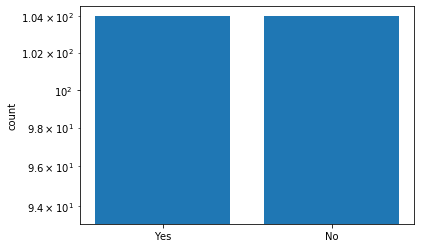

In [19]:
plot_positive_negative_counts(df,target_col)

# Split  with randomization

In [20]:
import numpy as np
len_=len(df)
train_data, validation_data, test_data = np.split(df.sample(frac=1, random_state=1729), [int(0.7 * len_), int(0.9 * len_)])

Using libSVM for performance.

In [21]:
from sklearn.datasets import dump_svmlight_file   

lengths = [] 

for d in [(train_data, 'train.libsvm'), ( validation_data, 'validation.libsvm'), (test_data, 'test.libsvm')]:
   dataset=d[0]
   file_ = d[1]
   lengths.append((dataset,len(dataset))
   dump_svmlight_file(X=dataset.drop([target_col], axis=1), y=dataset[target_col], f=d[1])

print('Length of datasets:', lengths )

s3 = boto3.resource('s3', region_name=region)#TODO Remove

for filename in ['train.libsvm', 'validation.libsvm']:
   s3.Bucket(bucket).Object(prefix + '/'+filename.split('.')[0]+'/'+filename).upload_file(filename)

SyntaxError: invalid syntax (<ipython-input-21-9207926b13e0>, line 9)

In [ ]:
def s3_path(subset):
  return sagemaker.s3_input(s3_data='s3://{}/{}/{}'.format(bucket, prefix,subset), content_type='libsvm')

s3_input_train = s3_path('train')
s3_input_validation =s3_path('validation')

---
## Train

Our data is now ready to be used to train a XGBoost model. The XGBoost algorithm has many tunable hyperparameters. Some of these hyperparameters are listed below; initially we'll only use a few of them.  

- `max_depth`: Maximum depth of a tree. As a cautionary note, a value too small could underfit the data, while increasing it will make the model more complex and thus more likely to overfit the data (in other words, the classic bias-variance tradeoff).
- `eta`: Step size shrinkage used in updates to prevent overfitting.  
- `eval_metric`: Evaluation metric(s) for validation data. For data sets such as this one with imbalanced classes, we'll use the AUC metric.
- `scale_pos_weight`: Controls the balance of positive and negative weights, again useful for data sets having imbalanced classes.

First we'll set up the parameters for an Amazon SageMaker Estimator object, and the hyperparameters for the algorithm itself.  The Estimator object from the Amazon SageMaker Python SDK is a convenient way to set up training jobs with a minimal amount of code.

In [ ]:
from sagemaker.amazon.amazon_estimator import get_image_uri

container = get_image_uri(region, 'xgboost','1.0-1')

xgb = sagemaker.estimator.Estimator(container,
                                    role, 
                                    base_job_name='fraud-detection-job',
                                    train_instance_count=1, 
                                    train_instance_type='ml.c5.xlarge',
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                    sagemaker_session=session)
scale_pos_weight=num_negative / num_positive  
num_positive, num_negative=count_positive_and_negative(df)

print('scale_pos_weight', f'{scale_pos_weight:.1f}')

xgb.set_hyperparameters(max_depth=3,
                        eta=0.1,
                        subsample=0.5,
                        eval_metric='auc',
                        objective='binary:logistic',
                        scale_pos_weight=scale_pos_weight,
                        num_round=100)


Run the hosted training job itself.

In [ ]:
%%time
xgb.fit({'train': s3_input_train, 'validation': s3_input_validation})

---
## Host

Now that we've trained the XGBoost algorithm on our data, we can deploy the trained model to an Amazon SageMaker hosted endpoint with one simple line of code.

In [ ]:
import datetime 
model = xgb.create_model()
container_def = model.prepare_container_def(instance_type='ml.m4.xlarge')
model_name = 'fraud' + datetime.datetime.now().isoformat().replace('.','-').replace(':','-')  
 
print('model_name', model_name)
 
session.create_model(model_name, role, container_def)

endpoint_config_name = session.create_endpoint_config(name=model_name,
                                                      model_name=model_name,
                                                      initial_instance_count=1,
                                                      instance_type='ml.m5.xlarge')

client = boto3.client('sagemaker')
updated_endpoint=client.update_endpoint(EndpointName='fraud-detection-job-2020-11-08-09-33-33-185', EndpointConfigName=endpoint_config_name)

#xgb_predictor = xgb.deploy(initial_instance_count=1,
#                          instance_type='ml.m5.xlarge')

In [ ]:
endpoint_name='fraud-detection-job-2020-11-08-09-33-33-185'
xgb_predictor = sagemaker.predictor.RealTimePredictor(endpoint=endpoint_name, sagemaker_session=sagemaker.Session())

print(xgb_predictor)
print(type(xgb_predictor))

---

## Evaluation

Now that we have our hosted endpoint, we can generate predictions from  the  test data set.

Compared actual to predicted values of whether the transaction was a "fraud" (`1`) or not (`0`).  Then we'll produce a  confusion matrix.

In [ ]:
xgb_predictor.content_type = 'text/x-libsvm'
xgb_predictor.deserializer = None

def do_predict(data):
    payload = '\n'.join(data)
    response = xgb_predictor.predict(payload).decode('utf-8')
    result = response.split(',')
    preds = [float((num)) for num in result]
    preds = [round(num) for num in preds]
    return preds

def batch_predict(data, batch_size):
    items = len(data)
    arrs = []
    
    for offset in range(0, items, batch_size):
        if offset+batch_size < items:
            results = do_predict(data[offset:(offset+batch_size)])
            arrs.extend(results)
        else:
            arrs.extend(do_predict(data[offset:items]))
        sys.stdout.write('.')
    return(arrs)

In [ ]:
%%time
import json

with open('test.libsvm', 'r') as f:
    payload = f.read().strip()

labels = [int(line.split(' ')[0]) for line in payload.split('\n')]
test_data = [line for line in payload.split('\n')]
preds = batch_predict(test_data, 100)

print ('\nError rate=%f' % ( sum(1 for i in range(len(preds)) if preds[i]!=labels[i]) /float(len(preds))))

Show confusion matrix.

In [ ]:
pd.crosstab(index=np.array(labels), columns=np.array(preds))

Clean up to save money

In [ ]:
session.delete_endpoint(xgb_predictor.endpoint)